# Issues with low cost HOSVD (Soledad's version)

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import time
import kagglehub
import json
from tqdm import tqdm
import os

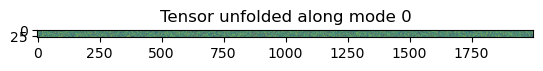

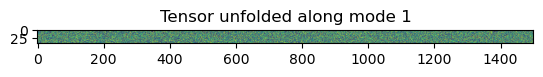

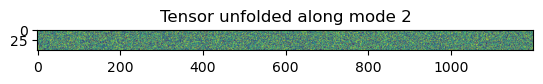

<Figure size 640x480 with 0 Axes>

In [ ]:
path_figs = "./FULL_EXPLANATION"
tensor = np.random.rand(30,40,50)
for i in range(tensor.ndim):
    plt.title(f"Tensor unfolded along mode {i}")
    plt.imshow(tl.unfold(tensor=tensor, mode=i))
    sampled_indices = np.arange(0, tensor.shape[2], 2)  # [0, 2, 4, ..., 48]
    axes[i, 1].axhline(y=idx, color='red', linewidth=1.5, alpha=0.7)

    plt.figure()

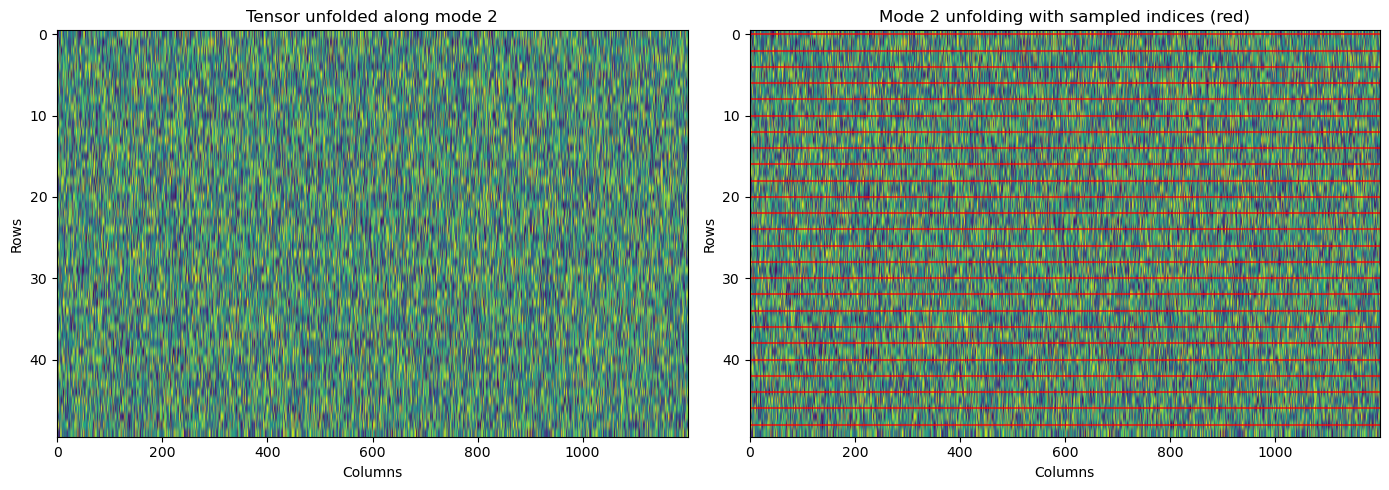

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl

path_figs = "./FULL_EXPLANATION"
tensor = np.random.rand(30, 40, 50)

# Subsample every second point in the last dimension (dimension 2)
sampled_indices = np.arange(0, tensor.shape[2], 2)  # [0, 2, 4, ..., 48]

# Create subplots: 1 row x 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mode 2 unfolding
unfolded = tl.unfold(tensor=tensor, mode=2)

# Left: regular unfolding
axes[0].set_title(f"Tensor unfolded along mode 2")
axes[0].imshow(unfolded, aspect='auto')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Rows')

# Right: unfolding with horizontal red lines
axes[1].set_title(f"Mode 2 unfolding with sampled indices (red)")
axes[1].imshow(unfolded, aspect='auto')
for idx in sampled_indices:
    axes[1].axhline(y=idx, color='red', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Rows')

plt.tight_layout()
plt.savefig(f'{path_figs}/mode2_unfolding_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
#this part of the code is taken from multiple RE analysis
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
# variable definition
subsample_x, subsample_y = 10,10
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}

Lx, Ly = 12.5, 15.6# domain size in D units

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")

tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
print(tensor.shape)
print("Data loading complete!")


Grid: 1600x2000, Subsampled: 160x200


100%|██████████| 200/200 [00:06<00:00, 29.75it/s]

(30, 40, 50)
Data loading complete!


In [65]:
tensor = tensor_[:, :, 4, :]

# Subsampled HOSVD

(30, 160)
(40, 120)
(50, 96)
0.025847196578979492
True


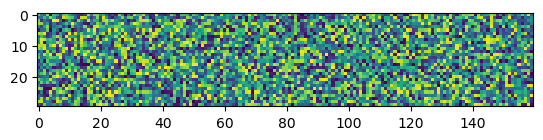

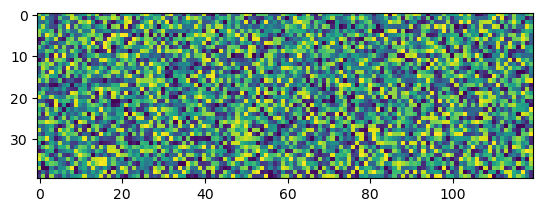

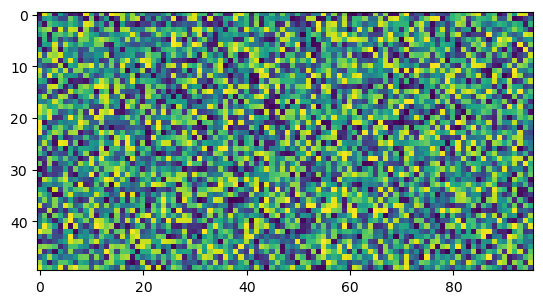

<Figure size 640x480 with 0 Axes>

In [85]:
sampling_ratio = 0.08
t_start = time.time()
factors = []
for mode in range(tensor.ndim):
    unfolded = tl.unfold(tensor, mode)
    m, n = unfolded.shape
    n_samples = int(n * sampling_ratio)        
    sample_indices = np.random.choice(n, size=n_samples, replace=False)
    sampled_matrix = unfolded[:, sample_indices]
    plt.imshow(sampled_matrix)
    plt.figure()
    print(sampled_matrix.shape)
    U, _, _ = np.linalg.svd(sampled_matrix, full_matrices=False)    
    factors.append(U)
core = tl.tenalg.multi_mode_dot(tensor, [U.T for U in factors], modes = [mode for mode in range(tensor.ndim)])
t_end = time.time()
print(t_end - t_start)

reconst = tl.tenalg.multi_mode_dot(core, factors, modes = [mode for mode in range(tensor.ndim)])
print(np.allclose(tensor, reconst))

# Low Cost HOSVD

This is without sign fixing and labor reorthogonalization, still the main idea is the same

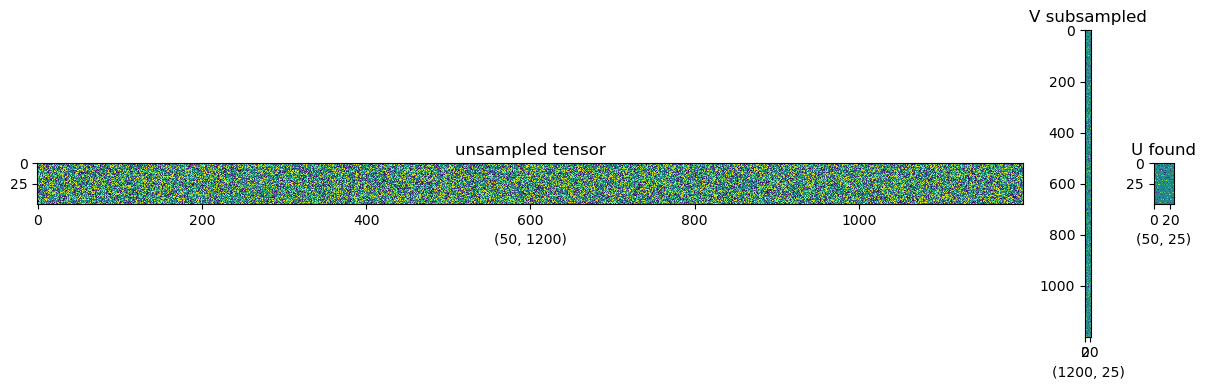

Time: 0.33698487281799316
False


In [97]:
t_start = time.time()
subsampled_tensor = tensor[:, :, ::2]
factors_lc = []

for mode in range(tensor.ndim):
    unfolded = tl.unfold(subsampled_tensor, mode)
    
    if mode != tensor.ndim - 1:
        U, _, _ = np.linalg.svd(unfolded, full_matrices=False)    
    else:
        U_red, sigma, V_red = np.linalg.svd(unfolded, full_matrices=False)        
        Q, R = np.linalg.qr(U_red)
        U_red = U_red @ np.linalg.inv(R)
        Q, R = np.linalg.qr(V_red.T)
        V_red = (V_red.T @ np.linalg.inv(R)).T
        ss = U_red.T @ unfolded @ V_red.T
        ss_sign = np.sign(np.diag(ss))
        V_red = V_red.T @ np.diag(ss_sign)
        V_red = V_red.T
        non_sampled_unfolded = tl.unfold(tensor, mode)
        U = non_sampled_unfolded @ V_red.T @ np.diag(1/sigma)
        Q, _ = np.linalg.qr(U)
        U = Q
        matrices = [non_sampled_unfolded,V_red.T,  U]

        widths = [m.shape[1] for m in matrices]

        fig, ax = plt.subplots(
            1, 3,
            figsize=(12, 4),
            gridspec_kw={'width_ratios': widths}
        )

        titles = ["unsampled tensor","V subsampled",  "U found"]

        for a, M, title in zip(ax, matrices, titles):
            a.imshow(M, aspect='equal', interpolation='none')
            a.set_title(title)
            a.set_xlabel(str(M.shape))

        plt.tight_layout()
        plt.savefig(fname = path_figs + "/matrices_product.png")
    
        plt.show()
    factors_lc.append(U)
core = tl.tenalg.multi_mode_dot(tensor, [U.T for U in factors_lc],modes=[mode for mode in range(tensor.ndim)])
t_end = time.time()
print(f"Time: {t_end - t_start}")

reconst_lc = tl.tenalg.multi_mode_dot(core, factors_lc, modes=[mode for mode in range(tensor.ndim)])
print(np.allclose(tensor, reconst))

In [95]:
print(path_figs + "matrices_product.png")

./FULL_EXPLANATIONmatrices_product.png


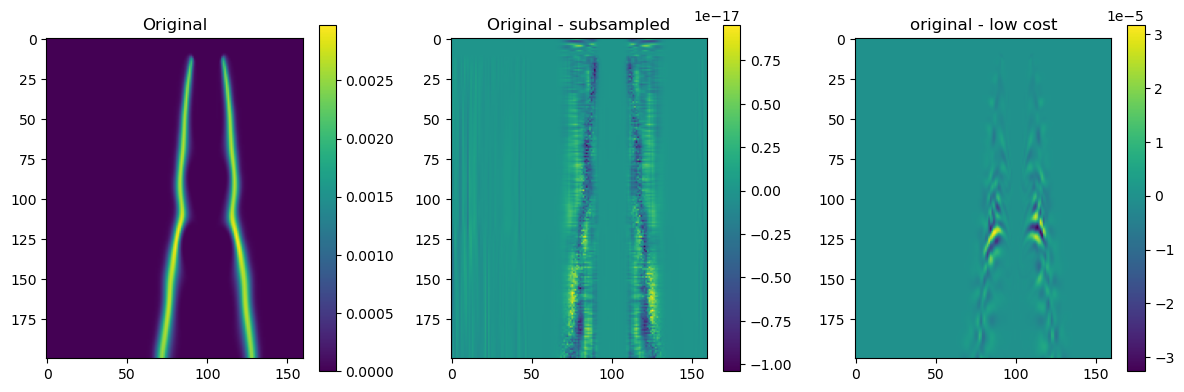

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im0 = ax[0].imshow(tensor[..., 0])
ax[0].set_title("Original")
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(np.subtract(tensor[...,0],reconst[..., 0]))
ax[1].set_title("Original - subsampled")
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(np.subtract(tensor[...,0],reconst_lc[..., 0]))
ax[2].set_title("original - low cost")
fig.colorbar(im2, ax=ax[2])

plt.tight_layout()
plt.show()

In [78]:
hosvd_factors = []
for mode in range(tensor.ndim):
    unfolded = tl.unfold(tensor, mode)
    U, _, _ = np.linalg.svd(unfolded, full_matrices=False)
    hosvd_factors.append(U)
    print(U.shape)

    

(200, 200)
(160, 160)
(200, 200)


In [69]:
for i, _ in enumerate(hosvd_factors):
    print(hosvd_factors[i].shape, factors[i].shape, factors_lc[i].shape)

(200, 200) (200, 200) (200, 200)
(160, 160) (160, 160) (160, 160)
(200, 200) (200, 200) (200, 100)


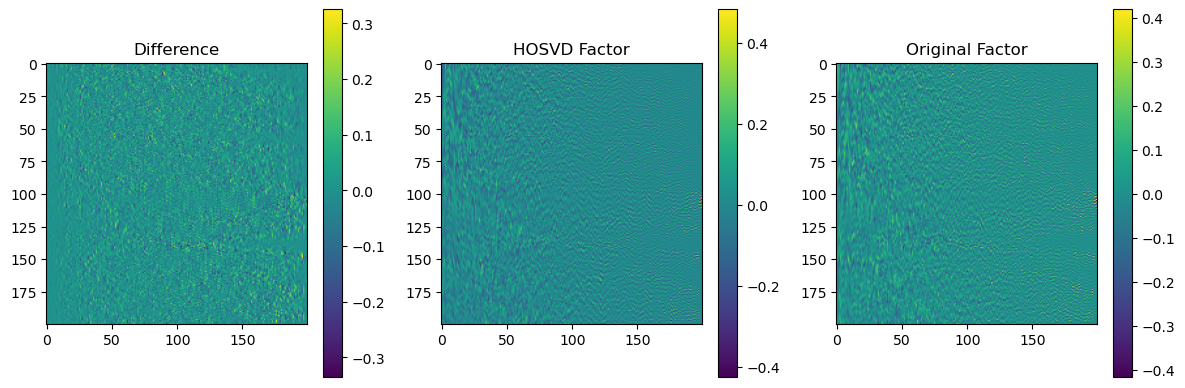

In [ ]:
for idx, factor in enumerate(hosvd_factors):
    if idx == len(hosvd_factors) - 1:
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        im0 = ax[0].imshow(np.subtract(np.abs(factor), np.abs(factors[i])))
        ax[0].set_title("Difference")
        fig.colorbar(im0, ax=ax[0])

        im1 = ax[1].imshow(factor)
        ax[1].set_title("HOSVD Factor")
        fig.colorbar(im1, ax=ax[1])

        im2 = ax[2].imshow(factors[i])
        ax[2].set_title("Original Factor")
        fig.colorbar(im2, ax=ax[2])

        plt.tight_layout()
        plt.show()

            
    